# cygnus-width-threshold

Evaluate different Q-value thresholds for Cygnus-Width

In [1]:
from collections import defaultdict
from importlib import reload
from matplotlib import colormaps
from matplotlib import pyplot as plt
import numpy as np
from utils import plots, stats, tables, utils

# Configuration

In [2]:
#base_dir = '/u/cmolder/GitHub/ChampSim/out/pythia/'
base_dir = '/u/cmolder/GitHub/ChampSim/out/cygnus'

suites = [
    #('spec06', 'one_phase'),
    ('spec06', 'weighted'),
    ('spec17', 'weighted'),
    ('cloudsuite', 'weighted'),
    ('gap', 'one_phase'),
    ('google', 'one_phase')
]
metrics  = [
    'ipc_improvement',
]
features = [
    {'Delta_Path', 'PC_Delta'}, 
]
prefetch_thresholds = [-10.0, -9.0, -8.0, -7.0, -6.0, -5.0, -4.0, -3.0, 
                       -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 
                       7.0, 8.0, 9.0, 10.0]

dyn_prefetch_thresholds = [30, 40, 50, 60, 70, 80, 90, 100]

max_degrees = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18]

dpi = 192

In [3]:
dfs = {
    'baseline': tables.load_stats_csv(
        base_dir, 'degreedyn/baseline.csv', 
        ['spp_dev2', 'spp_ppf_dev', 'bingo'], prefetchers_level='l2'),

    'pythia': tables.load_stats_csv_pythia(
        base_dir, 'degreedyn/pythia/bwaware3.csv',
        features, feature_key='pythia_features'),

    # 'pythia_width': tables.load_stats_csv_pythia(
    #     base_dir, #'degreedyn/bythio/bwaware3_pythialike_width_moreactions.csv',
    #     features, feature_key='bythio_features'),
}

for pt in prefetch_thresholds:
    # name = f'degreedyn/bythio/bwaware3_width_moreactions_threshold/{pt}prefetch'
    name = f'degreedyn/cygnus/bwaware3_width_moreactions_threshold/{pt}prefetch'
    dfs[pt] = tables.load_stats_csv_pythia(base_dir, f'{name}.csv', features,
                                           feature_key='cygnus_features')

for pt in dyn_prefetch_thresholds:
    name = f'degreedyn/cygnus/bwaware3_width_moreactions_dynthreshold/{pt}ppkc'
    dfs[f'dyn{pt}'] = tables.load_stats_csv_pythia(base_dir, f'{name}.csv', features,
                                                   feature_key='cygnus_features')
    
for deg in max_degrees:
    name = f'degreedyn/cygnus/bwaware3_width_moreactions_real_actionprio_maxdeg/{deg}deg'
    dfs[f'deg{deg}'] = tables.load_stats_csv_pythia(base_dir, f'{name}.csv', features,
                                                    feature_key='cygnus_features')
dfs[f'deg20'] = tables.load_stats_csv_pythia(
    base_dir, f'degreedyn/cygnus/bwaware3_width_moreactions_real_actionprio_maxdeg/unlimited.csv', 
    features, feature_key='cygnus_features')

In [69]:
dfs[-3.0]['Delta_Path, PC_Delta'].columns.to_list()

['run_name',
 'L1D_pref',
 'L2C_pref',
 'LLC_pref',
 'L1D_pref_degree',
 'L2C_pref_degree',
 'LLC_pref_degree',
 'num_cpus',
 'ipc',
 'ipc_baseline',
 'ipc_improvement',
 'total_stall_cycles',
 'total_stall_instructions',
 'memory_stall_cycles',
 'memory_stall_instructions',
 'dram_rq_row_buffer_hits',
 'dram_rq_row_buffer_misses',
 'dram_wq_row_buffer_hits',
 'dram_wq_row_buffer_misses',
 'pythia_features',
 'pythia_pooling',
 'pythia_action_called',
 'pythia_reward_cv',
 'pythia_reward_kldiv',
 'cygnus_features',
 'cygnus_reward_cv',
 'cygnus_reward_kldiv',
 'next_line_offset',
 'all_pref',
 'seed',
 'kilo_inst',
 'kilo_warmup_inst',
 'L1D_accesses',
 'L1D_accesses_baseline',
 'L1D_hits',
 'L1D_hits_baseline',
 'L1D_misses',
 'L1D_misses_baseline',
 'L1D_misses_mshr_hit',
 'L1D_miss_cycles',
 'L1D_miss_cycles_baseline',
 'L1D_miss_mshr_hit_cycles',
 'L1D_exposed_miss_cycles',
 'L1D_exposed_miss_mshr_hit_cycles',
 'L1D_unique_miss_cycles',
 'L1D_unique_miss_mshr_hit_cycles',
 'L1D_uni

# Plots

## Helper functions

In [6]:
def plot_thresholds_suites(data_df, suites=suites, metric='ipc_improvement',
                           colors=defaultdict(lambda: None), legend_kwargs={}, 
                           ymin=None, ymax=None,
                           dpi=None, figsize=None):
                           #suptitle=""):
    # Construct dataset
    keys = []
    for k in data_df.keys():
        if 'Cygnus-Width' in k:
            keys.append(k)
    keys = sorted(keys, key=lambda x: float(x.split(' ')[1]))
    Xs = [float(k.split(' ')[1]) for k in keys]
    data_df_ = {k: data_df[k] for k in keys}
    table = tables.gen_table_metric_all(data_df_, suites, metric,)
    
    # Plot
    fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
    for i, column in enumerate(table.columns):
        color = colors[column] if column in colors else None
        ax.plot(Xs, table[column], '.-', label=column, color=color)

    # Legend
    ax.legend(**legend_kwargs)

    # Axes
    ax.set_xlabel('Prefetch Threshold', fontsize=8)
    ax.set_ylabel(f'{utils.get_mean_type(metric)} {metric.replace("_", " ")}', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)
    ax.set_ylim(ymin=ymin, ymax=ymax)

    # Grid
    ax.grid(color='lightgray')
    ax.set_axisbelow(True)

    # Title
    # title = f'Threshold vs. {metric.replace("_", " ")} ({suptitle})'
    # fig.suptitle(title)
    fig.tight_layout()
    plt.show()


def plot_thresholds_traces(data_df, suite=('spec06', 'weighted'), metric='ipc_improvement',
                           legend_kwargs={}, 
                           ymin=None, ymax=None,
                           dpi=None, figsize=None):
                           #suptitle=""):
    # Construct dataset
    keys = []
    for k in data_df.keys():
        if 'Cygnus-Width' in k:
            keys.append(k)
    keys = sorted(keys, key=lambda x: float(x.split(' ')[1]))
    Xs = [float(k.split(' ')[1]) for k in keys]
    data_df_ = {k: data_df[k] for k in keys}
    table = tables.gen_table_metric(data_df_, suite=suite[0], phase=suite[1], 
                                    metric=metric, add_mean=False)

    # Plot
    fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
    #cm = plt.get_cmap('gist_rainbow')
    #ax.set_prop_cycle(color=[cm(1.*i/15) for i in range(15)])
    markers=['.', '^', '*']
    for idx, (i, row) in enumerate(table.iterrows()):
        trace = i.split('_')[0]
        ax.plot(Xs, row, ls='-', marker=markers[idx // 10], label=trace)

    # Legend
    ax.legend(**legend_kwargs)

    # # Axes
    ax.set_xlabel('Prefetch Threshold', fontsize=8)
    ax.set_ylabel(f'{utils.get_mean_type(metric)} {metric.replace("_", " ")}', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.axhline(0, color='black')

    # Grid
    ax.grid(color='lightgray')
    ax.set_axisbelow(True)

    # Title
    #title = f'Threshold vs. {metric.replace("_", " ")} ({suptitle})'
    #fig.suptitle(title)
    fig.tight_layout()
    plt.show()

## Static threshold

In [4]:
# Comparisons
degreedyn_1core_df = {}
for pt in prefetch_thresholds:
    degreedyn_1core_df[f'Cygnus-Width {pt}'] = dfs[pt]['Delta_Path, PC_Delta']

degreedyn_1core_df['SPP+PPF'] = dfs['baseline']['spp_ppf_dev']
# degreedyn_1core_df['Pythia-Width 3.0'] = dfs['pythia_width']['Delta_Path, PC_Delta']
degreedyn_1core_df['Pythia-Depth'] = dfs['pythia']['Delta_Path, PC_Delta']

# Legend parameters
degreedyn_1core_legend_kwargs = {
    'ncol': 6,
    'fontsize': 6.75,
    'loc': 'lower center',
    'bbox_to_anchor': (0.5, 1.0),
    'framealpha': 0.0,
}

degreedyn_1core_legend_kwargs_traces = {
    'ncol': 4,
    'fontsize': 6.75,
    'loc': 'lower center',
    'bbox_to_anchor': (0.5, 1.0),
    'framealpha': 0.0,
}

### Per-suite

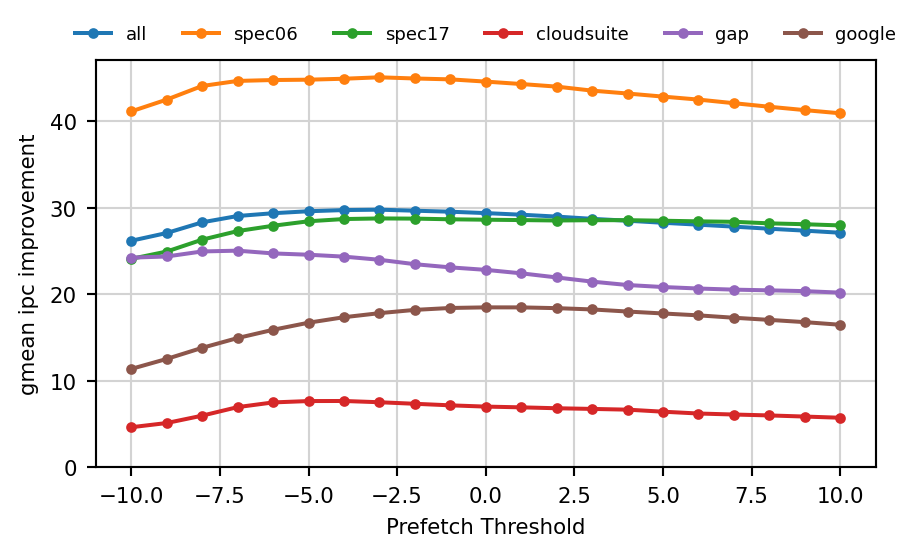

In [57]:
plot_thresholds_suites(degreedyn_1core_df, suites=suites, metric='ipc_improvement',
                       legend_kwargs=degreedyn_1core_legend_kwargs,
                       ymin=0,
                       dpi=dpi, figsize=(5, 3))

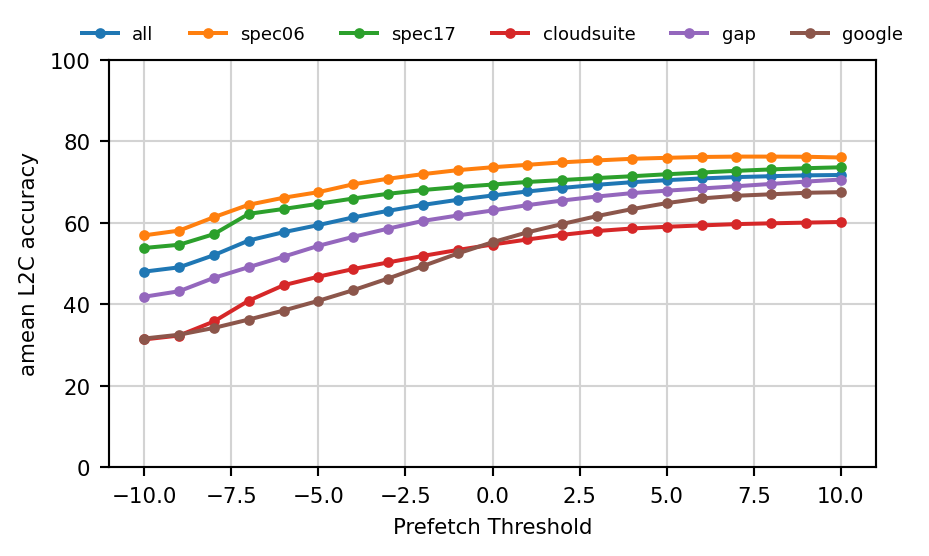

In [50]:
plot_thresholds_suites(degreedyn_1core_df, suites=suites, metric='L2C_accuracy',
                       legend_kwargs=degreedyn_1core_legend_kwargs,
                       ymin=0, ymax=100,
                       dpi=dpi, figsize=(5, 3))

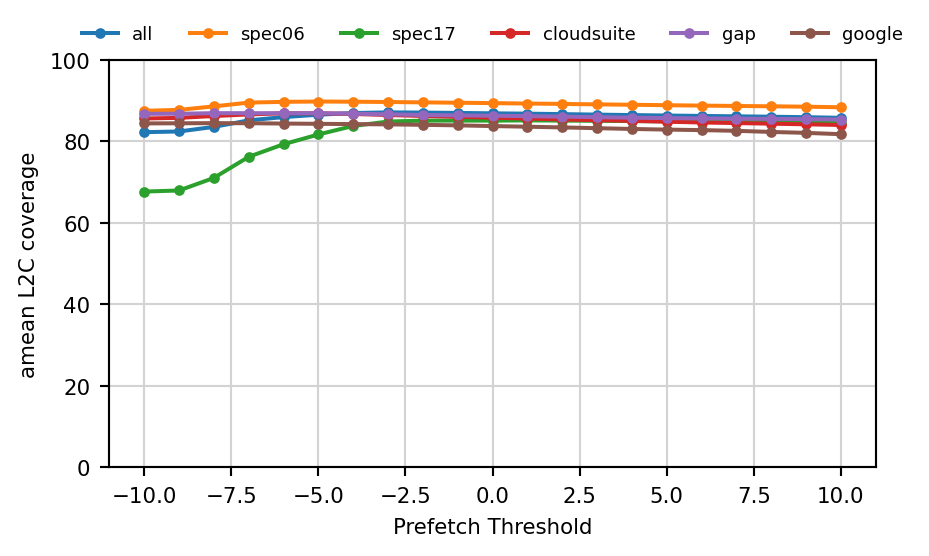

In [51]:
plot_thresholds_suites(degreedyn_1core_df, suites=suites, metric='L2C_coverage',
                       legend_kwargs=degreedyn_1core_legend_kwargs,
                       ymin=0, ymax=100,
                       dpi=dpi, figsize=(5, 3))

### Per-trace

#### IPC improvement

=== ('spec06', 'weighted') ===


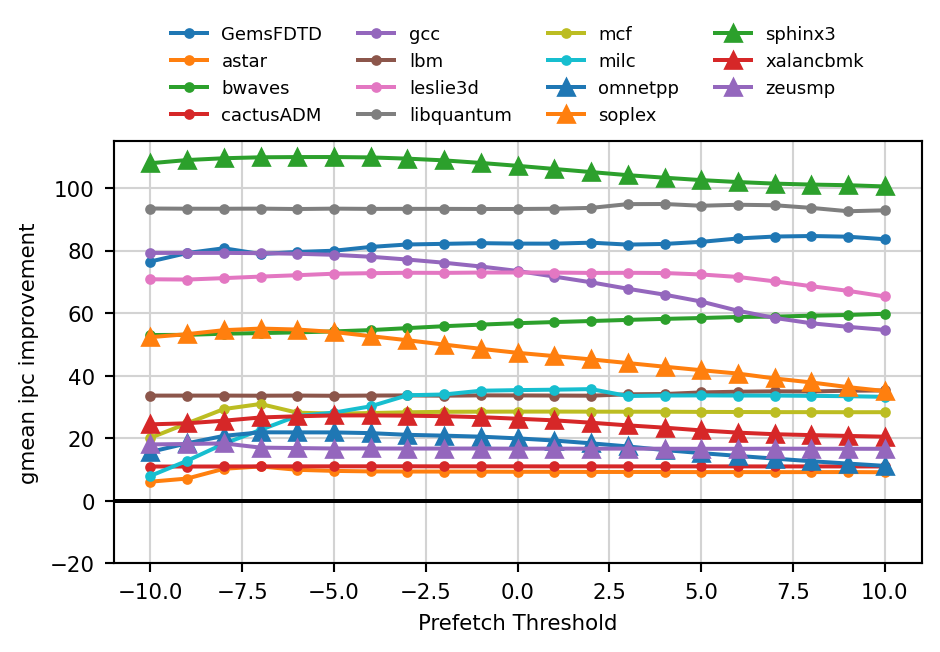

=== ('spec17', 'weighted') ===


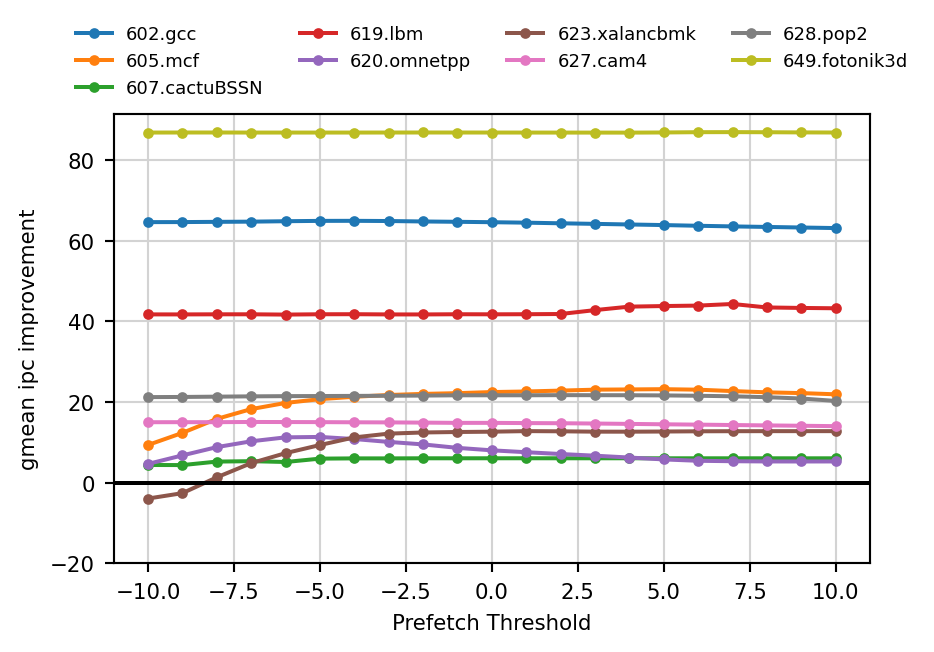

=== ('cloudsuite', 'weighted') ===


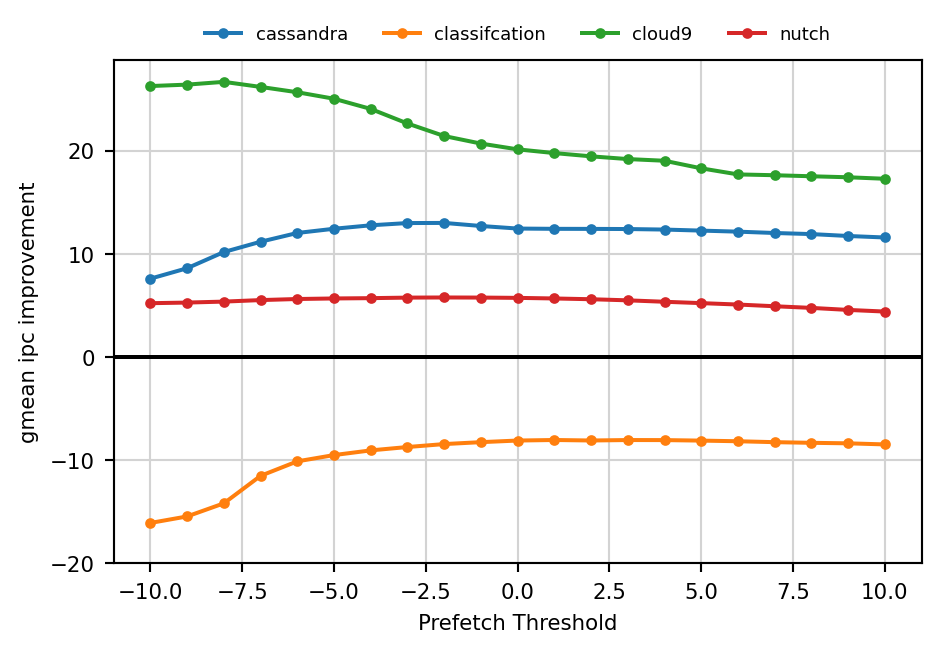

=== ('gap', 'one_phase') ===


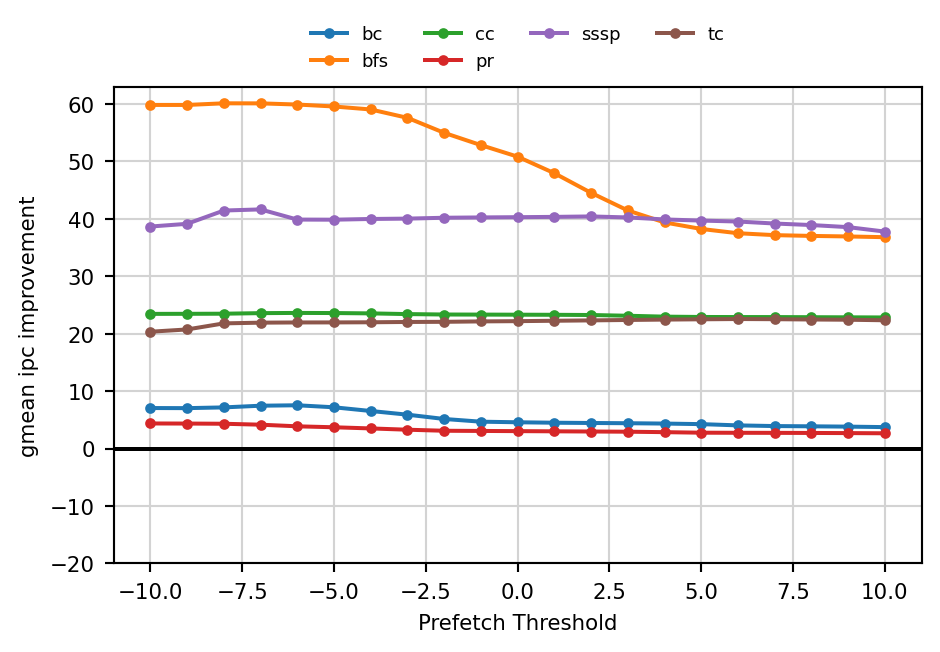

=== ('google', 'one_phase') ===


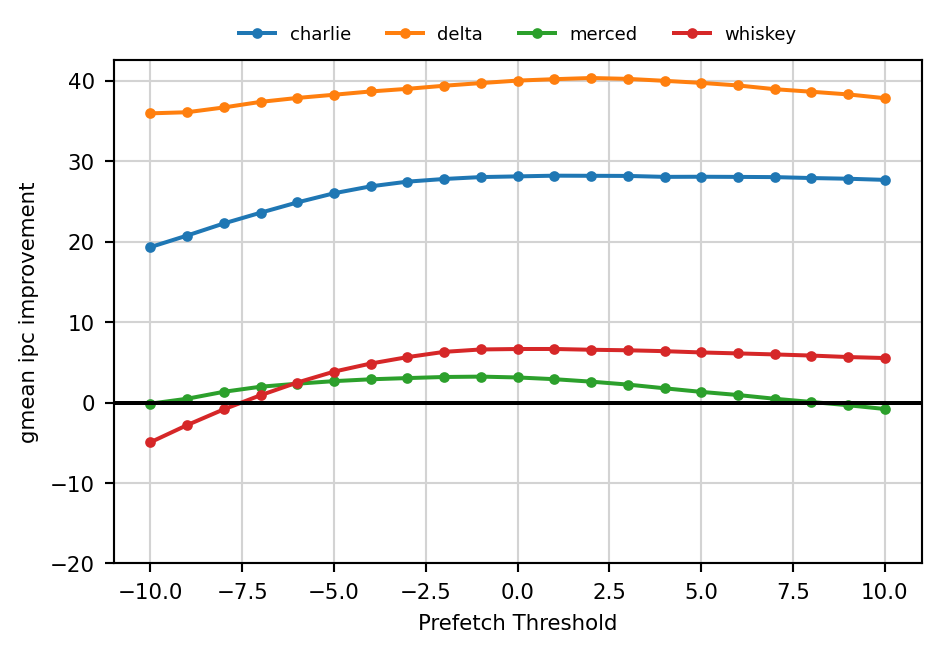

In [59]:
for suite in suites:
    print(f'=== {suite} ===')
    plot_thresholds_traces(degreedyn_1core_df, suite=suite, metric='ipc_improvement',
                           legend_kwargs=degreedyn_1core_legend_kwargs_traces,
                           ymin=-20,
                           dpi=dpi, figsize=(5, 3.5))

#### L2 accuracy

=== ('spec06', 'weighted') ===


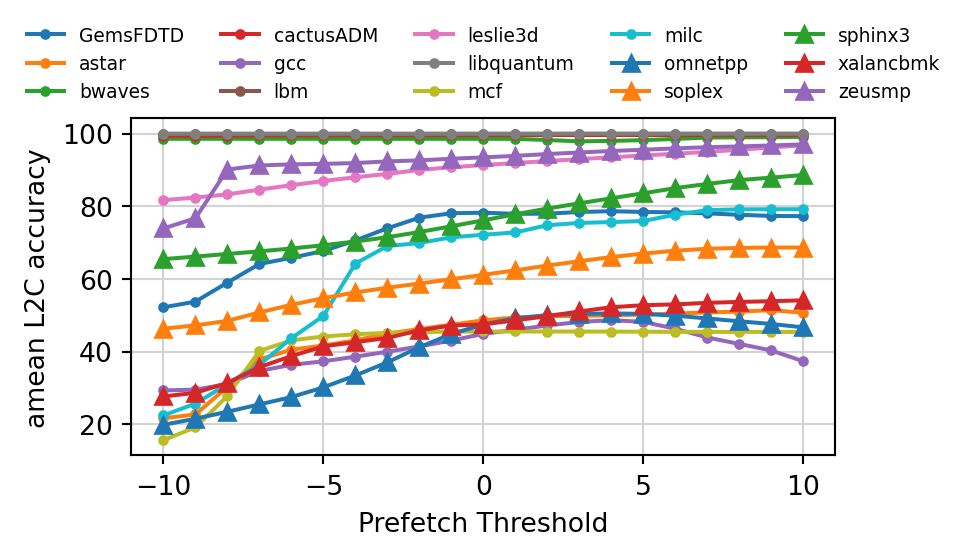

=== ('spec17', 'weighted') ===


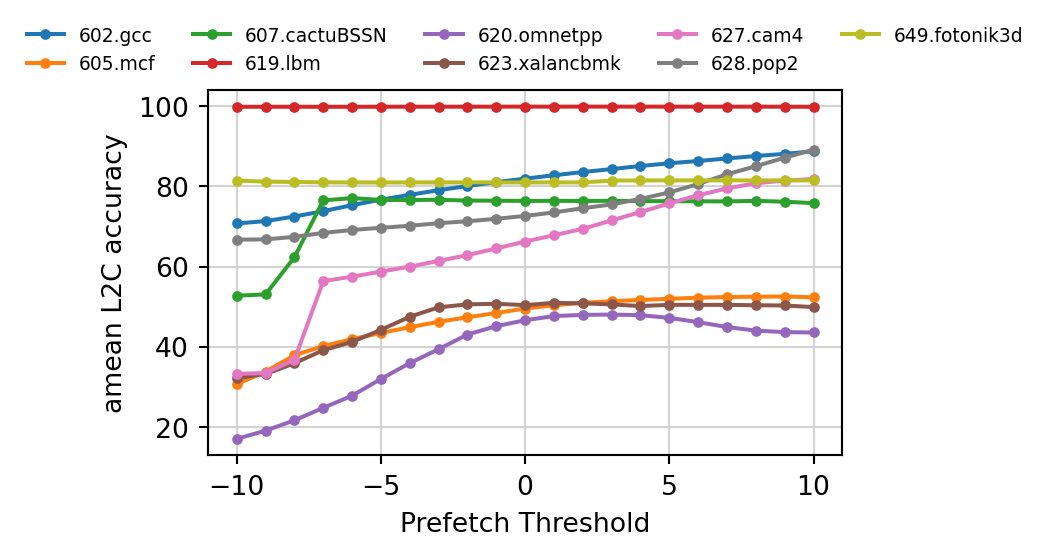

=== ('cloudsuite', 'weighted') ===


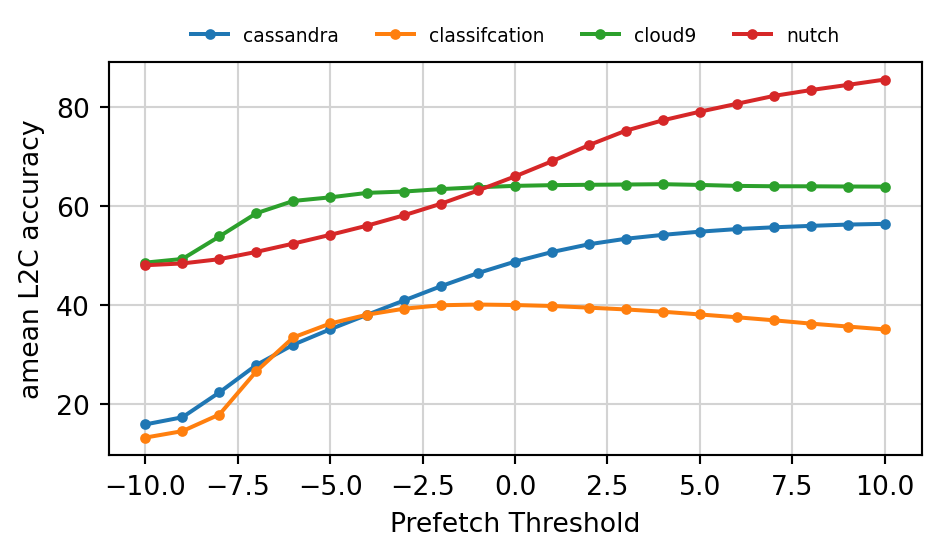

=== ('gap', 'one_phase') ===


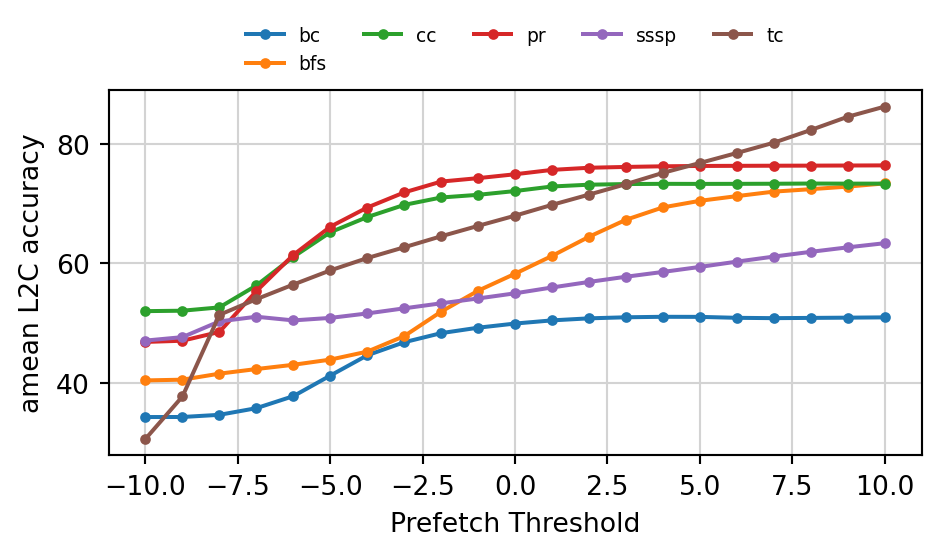

=== ('google', 'one_phase') ===


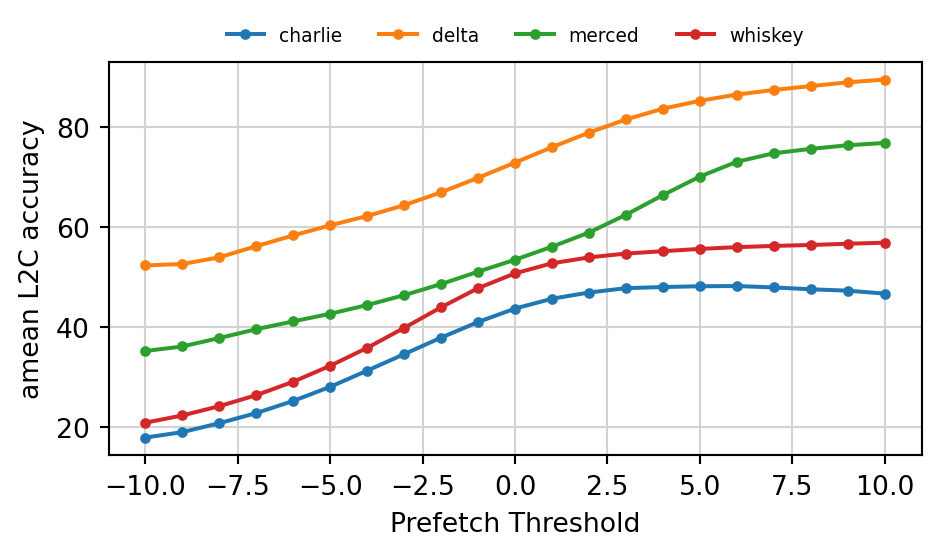

In [27]:
for suite in suites:
    print(f'=== {suite} ===')
    plot_thresholds_traces(degreedyn_1core_df, suite=suite, metric='L2C_accuracy',
                           legend_kwargs=degreedyn_1core_legend_kwargs,
                           dpi=dpi, figsize=(5, 3))

#### LLC avg. miss cycles

=== ('spec06', 'weighted') ===


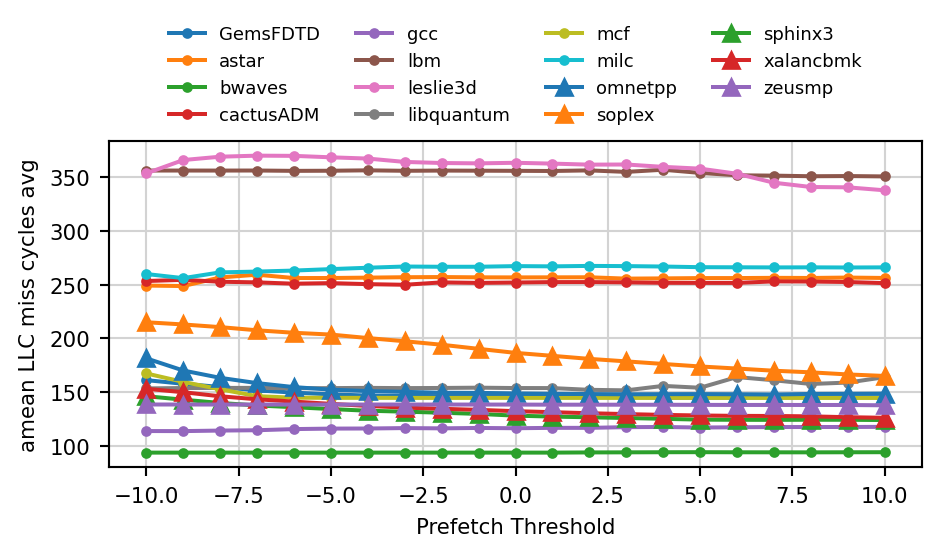

=== ('spec17', 'weighted') ===


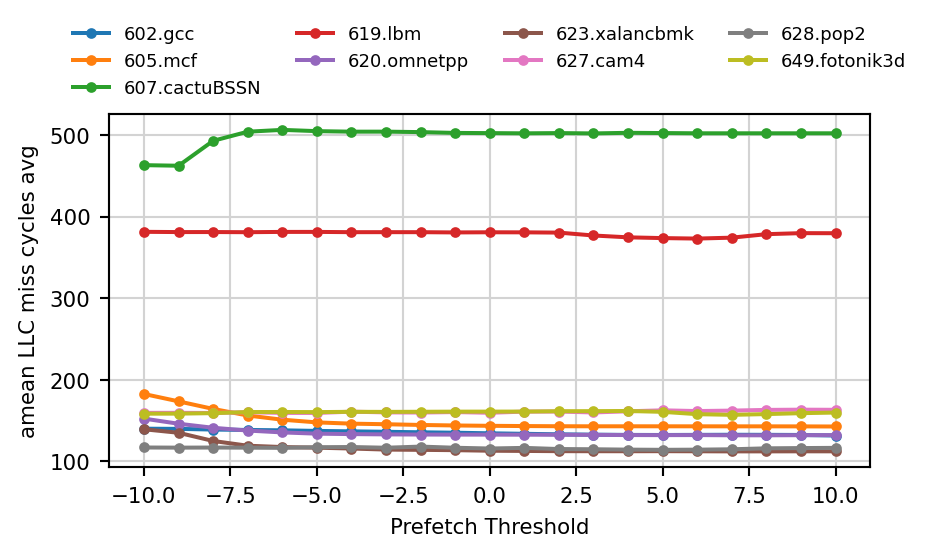

=== ('cloudsuite', 'weighted') ===


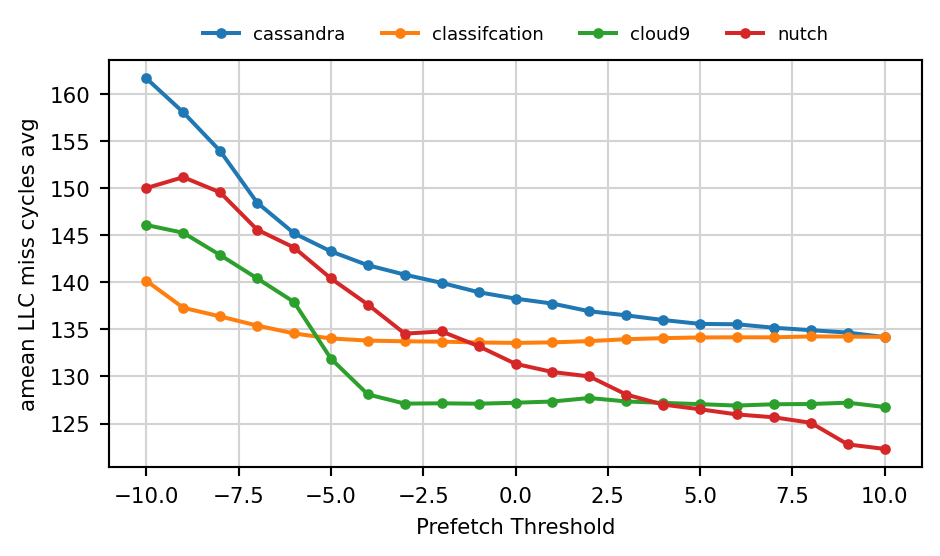

=== ('gap', 'one_phase') ===


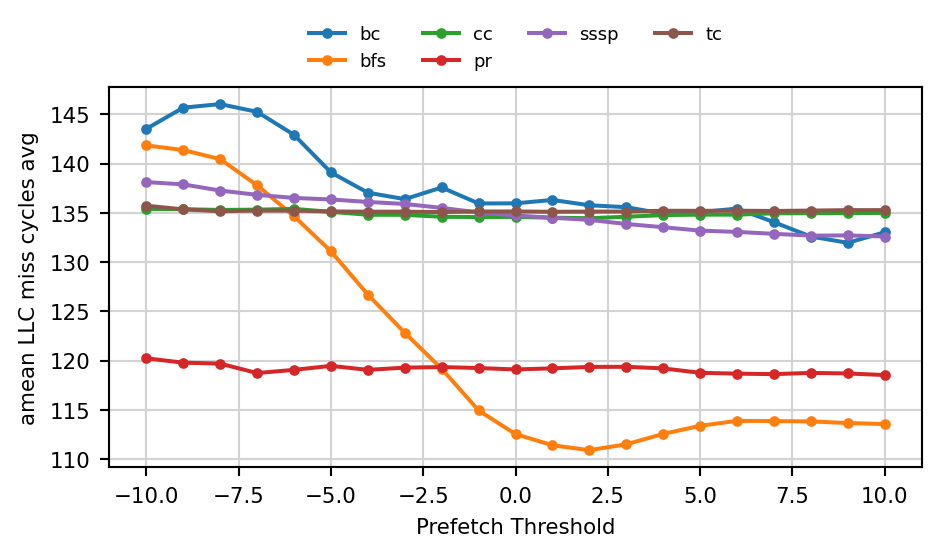

=== ('google', 'one_phase') ===


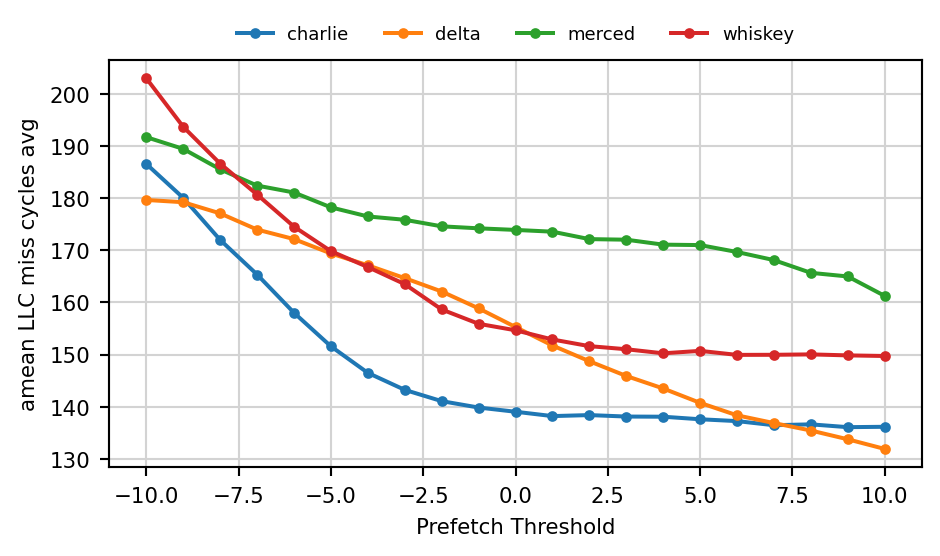

In [7]:
for suite in suites:
    print(f'=== {suite} ===')
    plot_thresholds_traces(degreedyn_1core_df, suite=suite, metric='LLC_miss_cycles_avg',
                           legend_kwargs=degreedyn_1core_legend_kwargs_traces,
                           dpi=dpi, figsize=(5, 3))

In [44]:
def plot_xy_traces(data_df, suite=('spec06', 'weighted'), 
                   x_metric='LLC_miss_cycles_avg', 
                   y_metric='ipc_improvement',
                   legend_kwargs={}, 
                   ymin=None, ymax=None,
                   dpi=None, figsize=None):
    # Construct dataset
    keys = []
    for k in data_df.keys():
        if 'Cygnus-Width' in k:
            keys.append(k)
    keys = sorted(keys, key=lambda x: float(x.split(' ')[1]))
    data_df_ = {k: data_df[k] for k in keys}
    table_x = tables.gen_table_metric(data_df_, suite=suite[0], phase=suite[1], 
                                      metric=x_metric, add_mean=False)
    table_y = tables.gen_table_metric(data_df_, suite=suite[0], phase=suite[1],
                                      metric=y_metric, add_mean=False)
    

    # # Plot
    fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
    # #cm = plt.get_cmap('gist_rainbow')
    # #ax.set_prop_cycle(color=[cm(1.*i/15) for i in range(15)])
    markers=['.', '^', '*']
    for idx, ((xi, xrow), (yi, yrow)) in enumerate(zip(table_x.iterrows(), table_y.iterrows())):
        trace = xi.split('_')[0]
        assert(xi == yi)
        ax.plot(xrow[8], yrow[8], marker='*', color='coral', zorder=10)#, fontsize=8, ha='center', va='center')
       
        ax.plot(xrow, yrow, ls='-', marker=markers[idx // 10], label=trace)

    # # Legend
    ax.legend(**legend_kwargs)

    # # # Axes
    ax.set_xlabel(x_metric, fontsize=8)
    ax.set_ylabel(y_metric, fontsize=8)
    ax.tick_params(axis='both', labelsize=8)
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.axhline(0, color='black')

    # # Grid
    ax.grid(color='lightgray')
    ax.set_axisbelow(True)

    # # Title
    # #title = f'Threshold vs. {metric.replace("_", " ")} ({suptitle})'
    # #fig.suptitle(title)
    fig.tight_layout()
    plt.show()

=== ('spec06', 'weighted') ===


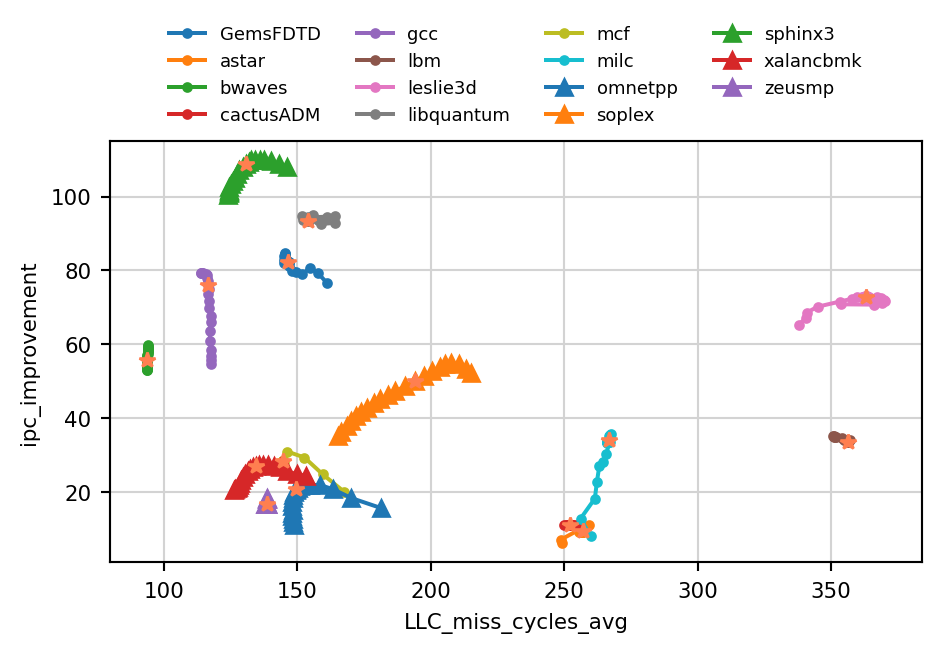

=== ('spec17', 'weighted') ===


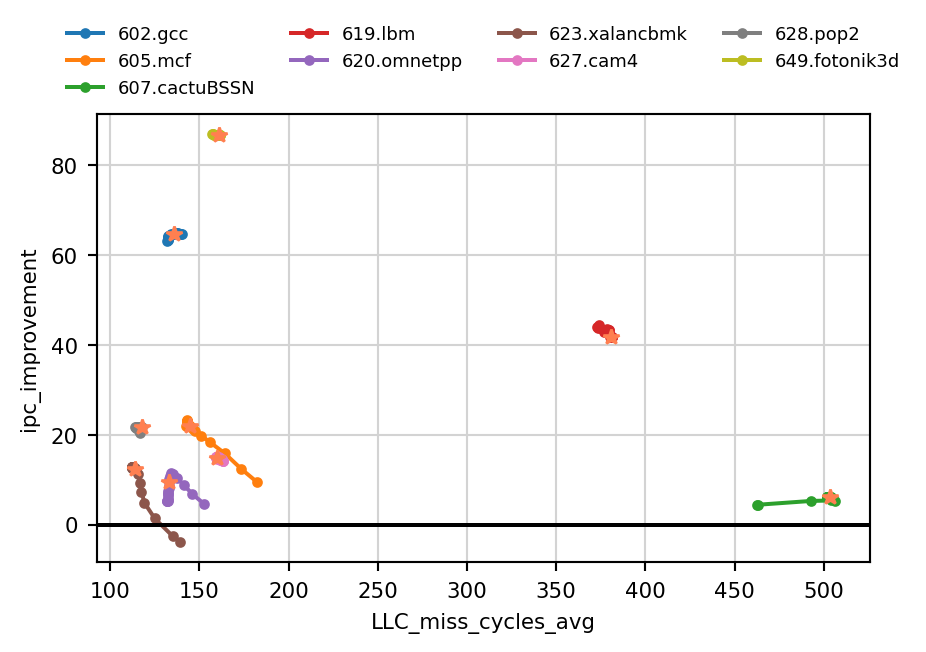

=== ('cloudsuite', 'weighted') ===


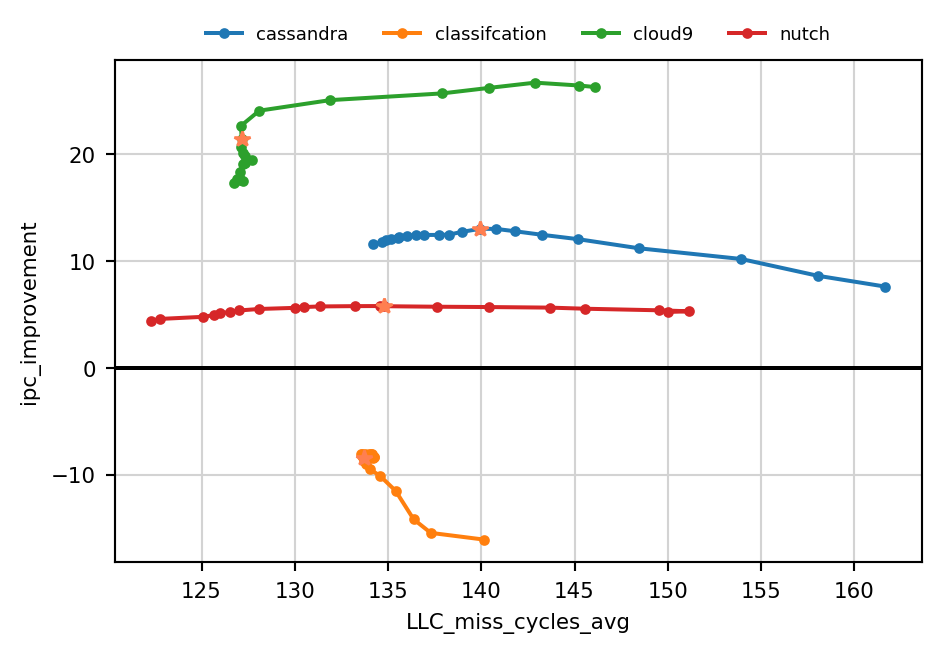

=== ('gap', 'one_phase') ===


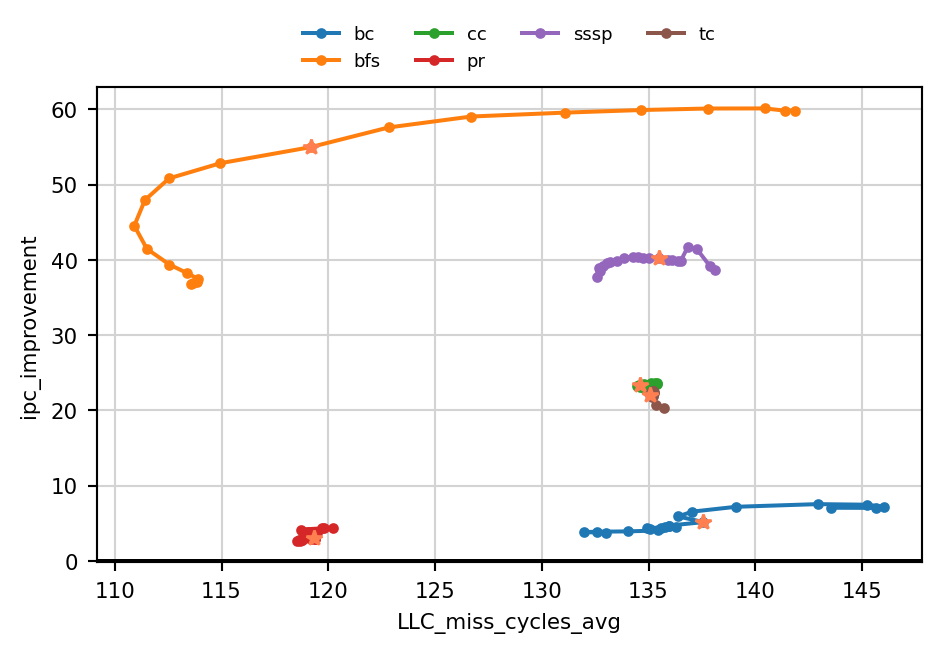

=== ('google', 'one_phase') ===


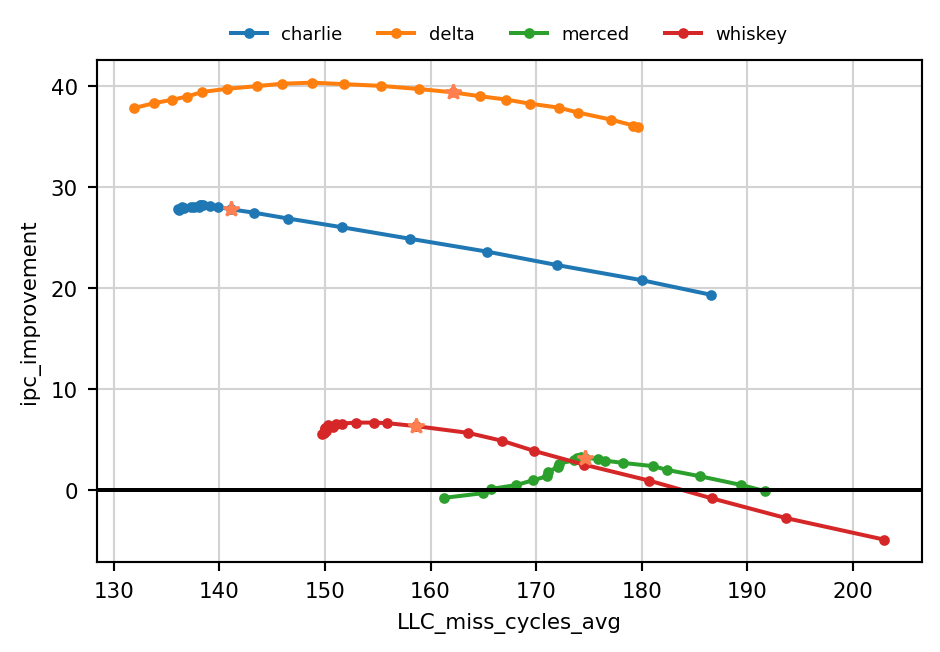

In [45]:
for suite in suites:
    print(f'=== {suite} ===')
    plot_xy_traces(degreedyn_1core_df, suite=suite, 
                   x_metric='LLC_miss_cycles_avg', y_metric='ipc_improvement',
                   legend_kwargs=degreedyn_1core_legend_kwargs_traces,
                   dpi=dpi, figsize=(5, 3.5))

## Dynamic threshold (PPKC)

In [18]:
# Comparisons
degreedyn_1core_dpt_df = {}
for pt in dyn_prefetch_thresholds:
    degreedyn_1core_dpt_df[f'Cygnus-Width {pt}'] = dfs[f'dyn{pt}']['Delta_Path, PC_Delta']
degreedyn_1core_dpt_df['SPP+PPF'] = dfs['baseline']['spp_ppf_dev']
degreedyn_1core_dpt_df['Pythia-Depth'] = dfs['pythia']['Delta_Path, PC_Delta']

# Legend parameters
degreedyn_1core_dpt_legend_kwargs = {
    'ncol': 5,
    'fontsize': 6,
    'loc': 'lower left',
    'bbox_to_anchor': (0.0, 1.0),
}

degreedyn_1core_dpt_suptitle = '512 KB, dynamic degree, 1 core'

### Per-suite

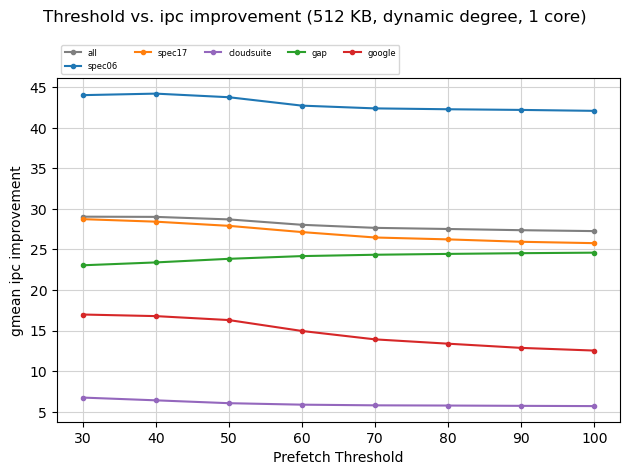

In [19]:
plot_thresholds_suites(degreedyn_1core_dpt_df, suites=suites, metric='ipc_improvement',
                       colors=suite_colors, legend_kwargs=degreedyn_1core_dpt_legend_kwargs,
                       dpi=dpi, figsize=(5, 3), suptitle=degreedyn_1core_dpt_suptitle)

### Per-trace

In [11]:
for suite in suites:
    print(f'=== {suite} ===')
    plot_thresholds_traces(degreedyn_1core_dpt_df, suite=suite, metric='ipc_improvement',
                           legend_kwargs=degreedyn_1core_dpt_legend_kwargs,
                           dpi=dpi, figsize=(5, 3), 
                           suptitle=degreedyn_1core_dpt_suptitle)

=== ('spec06', 'weighted') ===


NameError: name 'degreedyn_1core_dpt_df' is not defined

## Dynamic vs. static threshold

In [21]:
dyn_vs_static_df = {
    'Static -8.0': dfs[-8.0]['Delta_Path, PC_Delta'],
    'Static -3.0': dfs[-3.0]['Delta_Path, PC_Delta'],
    'Static +2.0': dfs[2.0]['Delta_Path, PC_Delta'],
    #'Static -7.0': dfs[-7.0]['Delta_Path, PC_Delta'],
    'Dynamic 30': dfs['dyn30']['Delta_Path, PC_Delta'],
    'Dynamic 40': dfs['dyn40']['Delta_Path, PC_Delta'],
    'Dynamic 50': dfs['dyn50']['Delta_Path, PC_Delta'],
    'Dynamic 60': dfs['dyn60']['Delta_Path, PC_Delta'],
    'Dynamic 70': dfs['dyn70']['Delta_Path, PC_Delta'],
    'Dynamic 80': dfs['dyn80']['Delta_Path, PC_Delta'],
    'Dynamic 90': dfs['dyn90']['Delta_Path, PC_Delta'],
    'Dynamic 100': dfs['dyn100']['Delta_Path, PC_Delta'],
    #'SPP+PPF': dfs['baseline']['spp_ppf_dev'],
}

dyn_vs_static_colors = defaultdict(lambda: None, {
    'Static -8.0': colormaps['Greys'](0.4),
    'Static -3.0': colormaps['Greys'](0.5),
    'Static +2.0': colormaps['Greys'](0.6),
    #'Static -7.0': colormaps['Greys'](0.7),
    'Dynamic 30': colormaps['viridis'](0.0),
    'Dynamic 40': colormaps['viridis'](0.15),
    'Dynamic 50': colormaps['viridis'](0.3),
    'Dynamic 60': colormaps['viridis'](0.45),
    'Dynamic 70': colormaps['viridis'](0.6),
    'Dynamic 80': colormaps['viridis'](0.75),
    'Dynamic 90': colormaps['viridis'](0.9),
    'Dynamic 100': colormaps['viridis'](1.0),
})

dyn_vs_static_legend_kwargs = {
    'ncol': 4,
    'fontsize': 7,
    'loc': 'lower center',
    'bbox_to_anchor': (0.5, 1.0),
    'framealpha': 0.0,
}

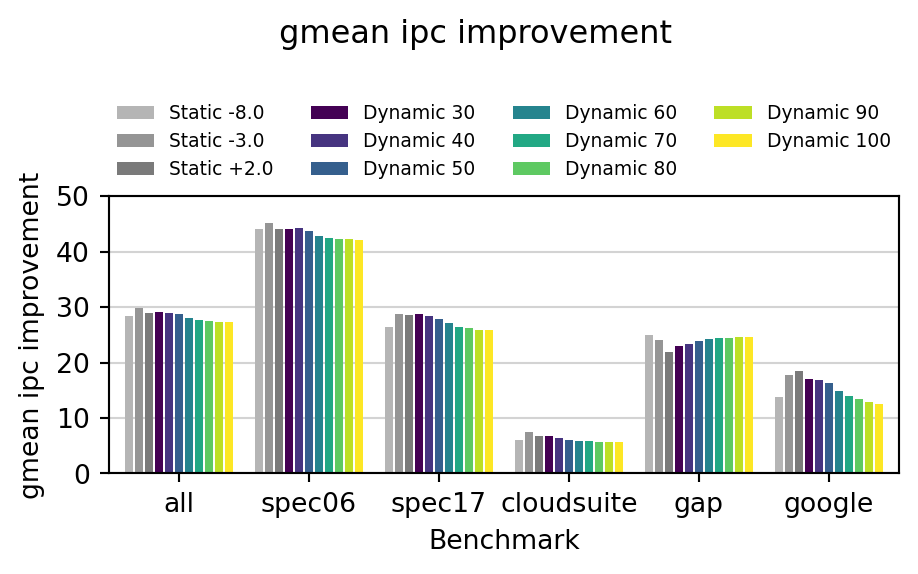

In [22]:
plots.plot_metric_means(dyn_vs_static_df, suites=suites, metric='ipc_improvement',
                        colors=dyn_vs_static_colors,
                        legend_kwargs=dyn_vs_static_legend_kwargs,
                        figsize=(5, 3), dpi=dpi)

=== spec06 weighted ===
=== spec17 weighted ===
=== cloudsuite weighted ===
=== gap one_phase ===
=== google one_phase ===


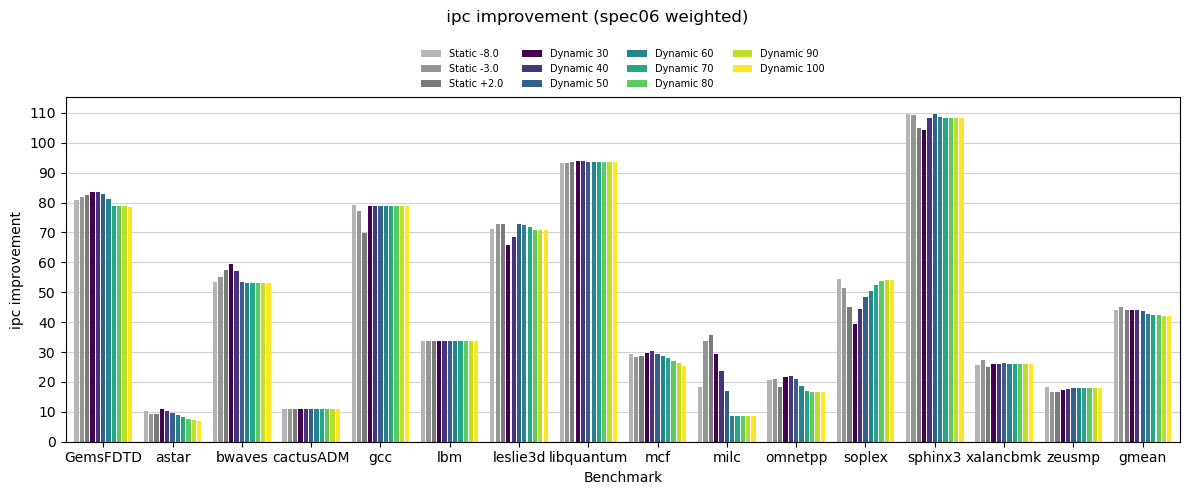

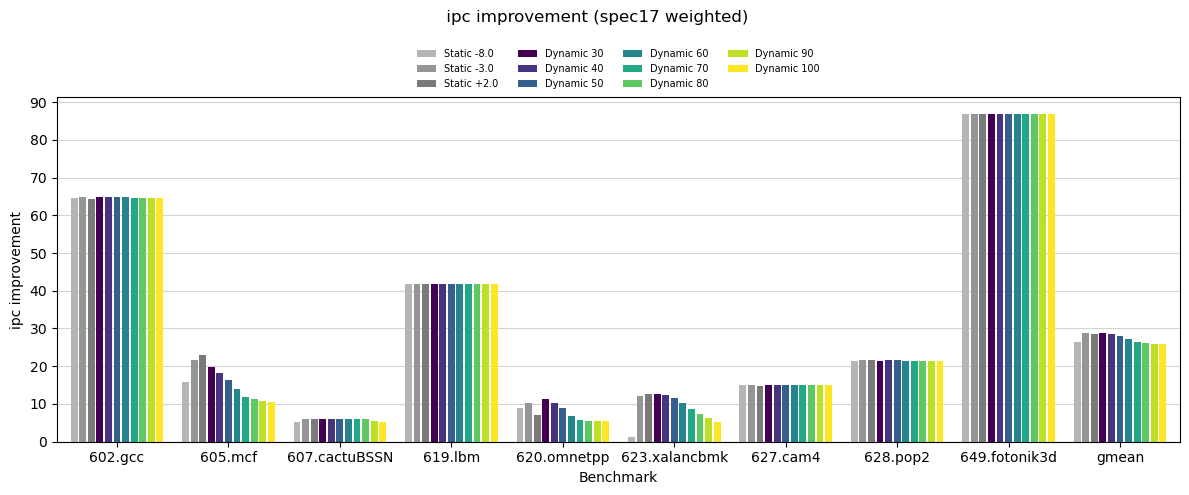

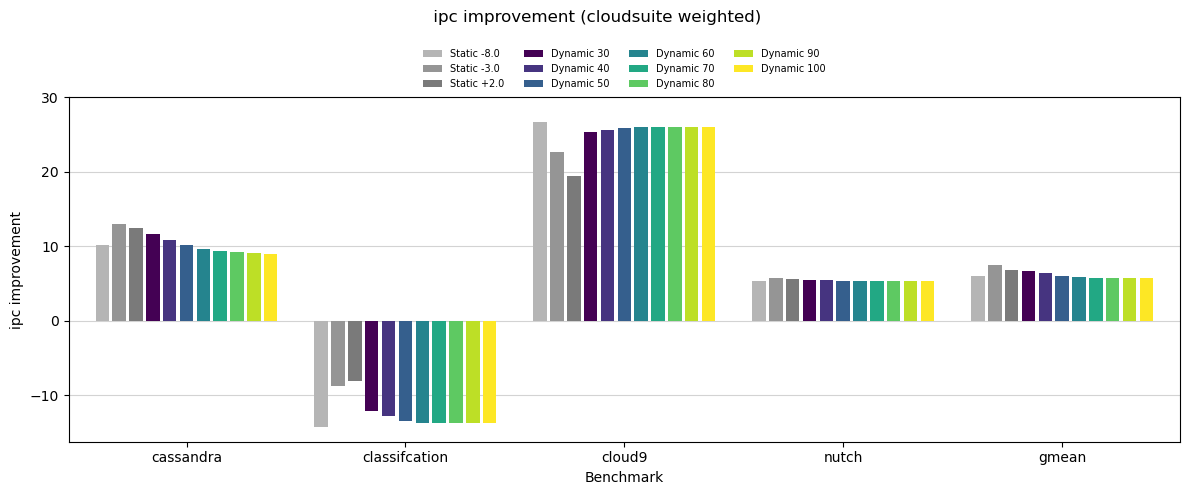

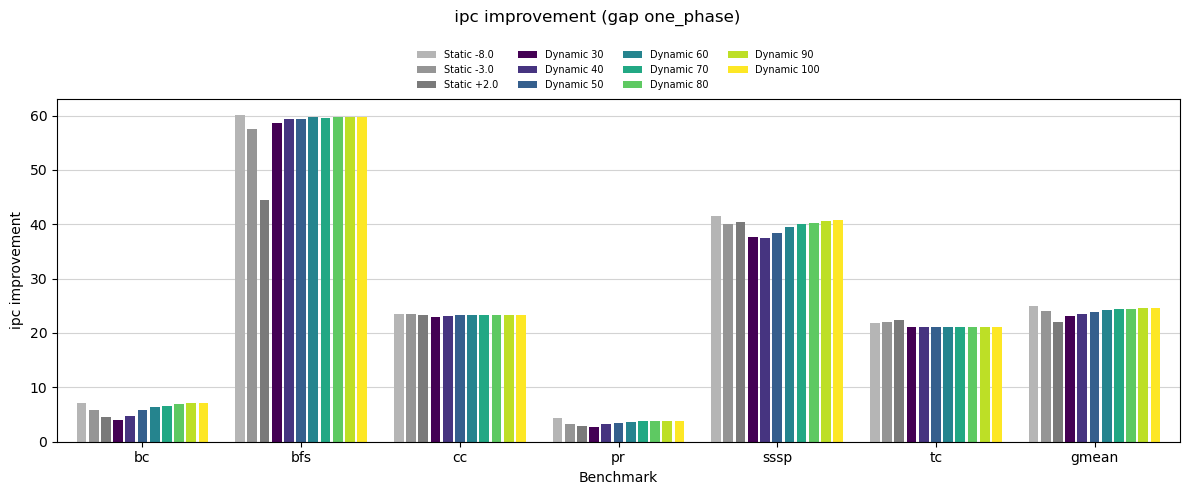

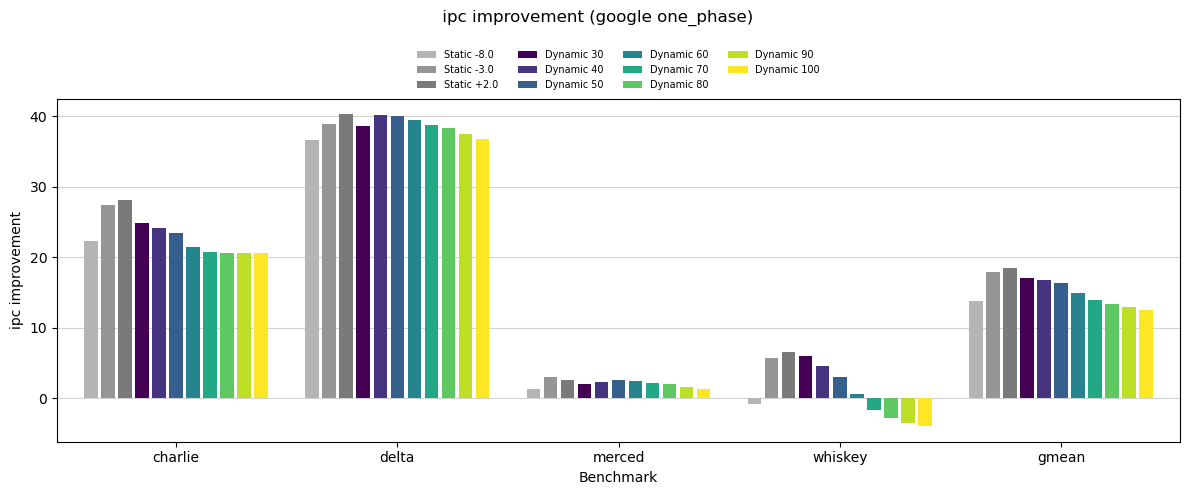

In [23]:
plots.plot_everything(dyn_vs_static_df, suites=suites, metrics=metrics,
                      colors=dyn_vs_static_colors,
                      legend_kwargs=dyn_vs_static_legend_kwargs,
                      figsize=(12, 5))

## Maximum degree
+action priority, MSHR awareness, real config

In [30]:
# Comparisons
degreedyn_1core_mdeg_df = {}
for mdeg in max_degrees:
    degreedyn_1core_mdeg_df[f'Cygnus-Width {mdeg}'] = dfs[f'deg{mdeg}']['Delta_Path, PC_Delta']
degreedyn_1core_mdeg_df['Cygnus-Width 20'] = dfs['degunlimited']['Delta_Path, PC_Delta']

# Legend parameters
degreedyn_1core_mdeg_legend_kwargs = {
    'ncol': 5,
    'fontsize': 7,
    'loc': 'lower center',
    'bbox_to_anchor': (0.5, 1.0),
    'framealpha': 0.0,
}

degreedyn_1core_mdeg_suptitle = '512 KB, dynamic degree, 1 core'

### Per-suite

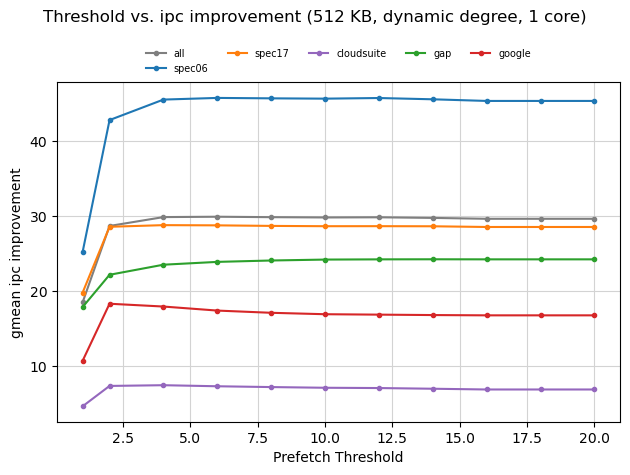

In [31]:
plot_thresholds_suites(degreedyn_1core_mdeg_df, suites=suites, metric='ipc_improvement',
                       colors=suite_colors, legend_kwargs=degreedyn_1core_mdeg_legend_kwargs,
                       #dpi=dpi, figsize=(5, 3), 
                       suptitle=degreedyn_1core_mdeg_suptitle)

### Per-trace

=== ('spec06', 'weighted') ===


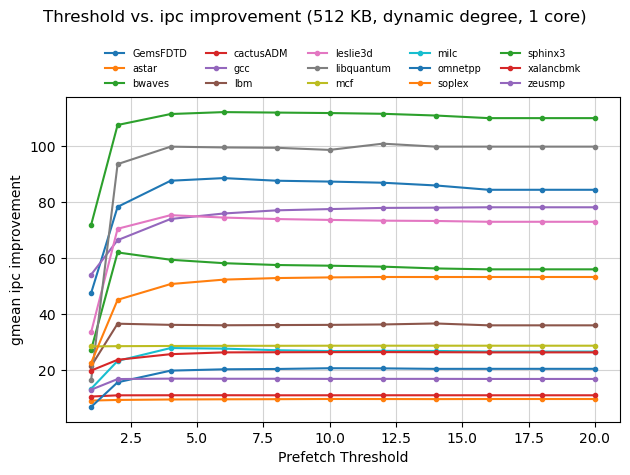

=== ('spec17', 'weighted') ===


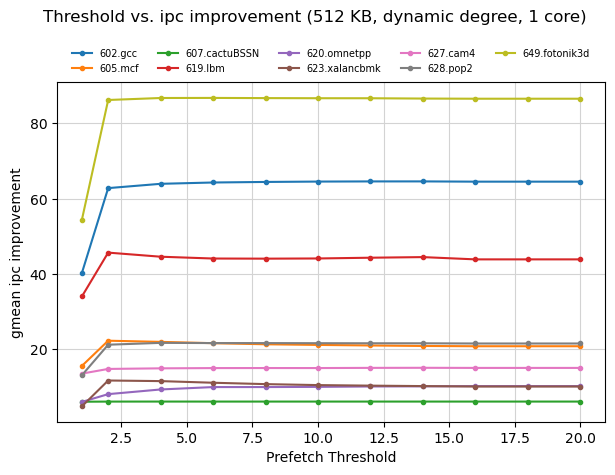

=== ('cloudsuite', 'weighted') ===


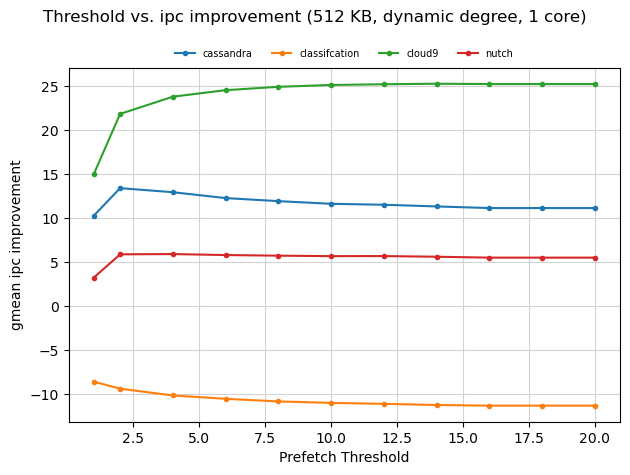

=== ('gap', 'one_phase') ===


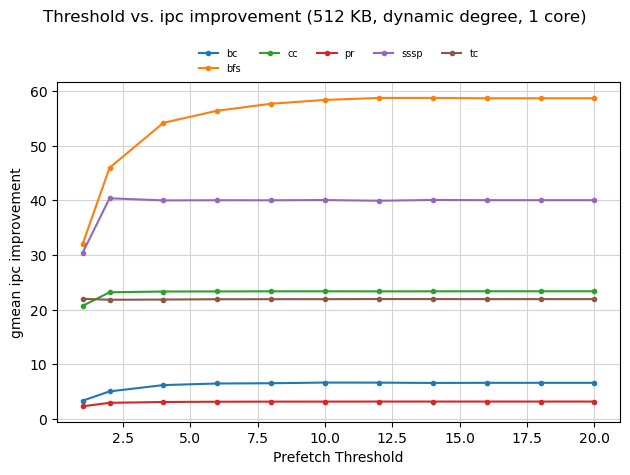

=== ('google', 'one_phase') ===


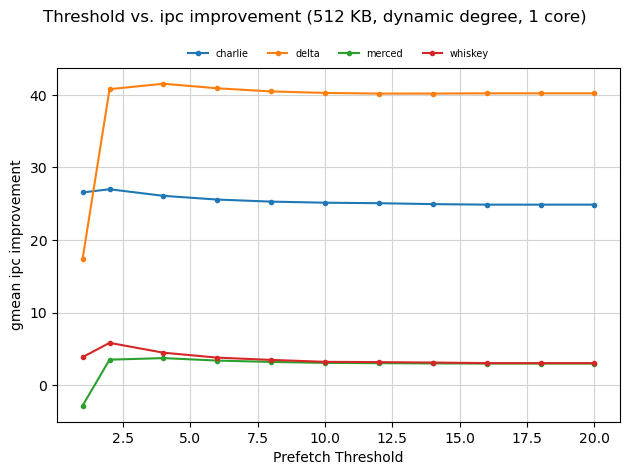

In [32]:
for suite in suites:
    print(f'=== {suite} ===')
    plot_thresholds_traces(degreedyn_1core_mdeg_df, suite=suite, metric='ipc_improvement',
                           legend_kwargs=degreedyn_1core_mdeg_legend_kwargs,
                           #dpi=dpi, figsize=(5, 3), 
                           suptitle=degreedyn_1core_mdeg_suptitle)

# Tables

## Static threshold

### IPC improvement

In [66]:
tables.table_everything(degreedyn_1core_df, suites=suites, metrics=['ipc_improvement'])

=== spec06 weighted ===
ipc_improvement


,Cygnus-Width -10.0,Cygnus-Width -9.0,Cygnus-Width -8.0,Cygnus-Width -7.0,Cygnus-Width -6.0,Cygnus-Width -5.0,Cygnus-Width -4.0,Cygnus-Width -3.0,Cygnus-Width -2.0,Cygnus-Width -1.0,...,Cygnus-Width 3.0,Cygnus-Width 4.0,Cygnus-Width 5.0,Cygnus-Width 6.0,Cygnus-Width 7.0,Cygnus-Width 8.0,Cygnus-Width 9.0,Cygnus-Width 10.0,SPP+PPF,Pythia-Depth
run_name,,,,,,,,,,,,,,,,,,,,,
GemsFDTD_weighted,76.506362,79.217565,80.744229,78.905852,79.568335,79.958681,81.171311,81.956088,82.160341,82.375905,...,81.918232,82.129340,82.789958,83.878950,84.492089,84.660956,84.438968,83.629874,101.467501,85.386640
astar_weighted,6.137951,7.137131,10.263243,11.011136,9.933387,9.590038,9.424805,9.385101,9.371122,9.343328,...,9.243220,9.228947,9.206503,9.212977,9.198766,9.202998,9.217025,9.154810,6.913059,6.840740
bwaves_weighted,53.015567,53.067548,53.440077,53.631733,53.861591,54.171593,54.590843,55.223421,55.833738,56.343521,...,57.851424,58.176336,58.448278,58.784172,58.897320,59.193109,59.424194,59.812200,61.281410,37.056804
cactusADM_weighted,10.986443,10.979311,10.999577,11.022988,11.035810,11.042726,11.050939,11.057383,11.041648,11.042126,...,11.024808,11.021673,11.024598,11.022721,11.011866,11.020032,11.012725,11.008901,10.624407,10.359788
gcc_weighted,79.249567,79.264223,79.263486,79.187336,78.984408,78.649902,78.024800,77.138545,76.123985,74.910715,...,67.798499,65.915627,63.711907,60.767313,58.479105,56.767903,55.631801,54.642964,28.026572,19.597798
lbm_weighted,33.654584,33.654584,33.659583,33.620853,33.665452,33.597346,33.664536,33.710299,33.618996,33.732784,...,34.064675,34.157796,34.671649,34.891913,35.021851,34.966400,35.217539,35.285199,43.441944,36.226024
leslie3d_weighted,70.836504,70.744479,71.195296,71.690550,72.131703,72.612196,72.781274,72.916523,72.875853,72.984575,...,72.900451,72.831123,72.364398,71.571127,70.169029,68.610735,67.128716,65.330500,83.481490,66.927458
libquantum_weighted,93.452531,93.386797,93.373924,93.416052,93.288011,93.411096,93.329959,93.342585,93.337174,93.297936,...,94.853178,94.893069,94.332061,94.651193,94.494811,93.648185,92.576993,92.875215,109.782222,82.715361
mcf_weighted,20.141021,24.775159,29.348515,30.975980,28.192964,27.907073,28.073136,28.326285,28.468652,28.514003,...,28.503701,28.491734,28.441699,28.408528,28.373606,28.365562,28.344074,28.353627,11.989272,30.557541


=== spec17 weighted ===
ipc_improvement


,Cygnus-Width -10.0,Cygnus-Width -9.0,Cygnus-Width -8.0,Cygnus-Width -7.0,Cygnus-Width -6.0,Cygnus-Width -5.0,Cygnus-Width -4.0,Cygnus-Width -3.0,Cygnus-Width -2.0,Cygnus-Width -1.0,...,Cygnus-Width 3.0,Cygnus-Width 4.0,Cygnus-Width 5.0,Cygnus-Width 6.0,Cygnus-Width 7.0,Cygnus-Width 8.0,Cygnus-Width 9.0,Cygnus-Width 10.0,SPP+PPF,Pythia-Depth
run_name,,,,,,,,,,,,,,,,,,,,,
602.gcc_weighted,64.627690,64.640861,64.695905,64.746632,64.852796,64.937188,64.951100,64.900100,64.790653,64.706581,...,64.196370,64.045675,63.896737,63.724033,63.567231,63.434937,63.293829,63.154830,66.506676,63.015705
605.mcf_weighted,9.379097,12.377440,15.843894,18.277054,19.798023,20.738478,21.334956,21.767090,22.041930,22.226052,...,23.090412,23.149549,23.213297,23.086167,22.739508,22.430289,22.238628,21.940455,19.551786,11.886368
607.cactuBSSN_weighted,4.415149,4.391766,5.257832,5.361778,5.156423,5.992495,6.052921,6.051801,6.077673,6.073721,...,6.079563,6.082727,6.077403,6.076154,6.076683,6.077722,6.072013,6.073363,5.832238,6.729014
619.lbm_weighted,41.753239,41.746670,41.774663,41.777888,41.703218,41.786163,41.800081,41.745141,41.740560,41.791946,...,42.817622,43.677739,43.823579,43.933926,44.335859,43.473568,43.352100,43.267514,19.782796,18.504989
620.omnetpp_weighted,4.685947,6.796839,8.843779,10.291499,11.269208,11.371874,10.846539,10.135566,9.517124,8.659681,...,6.720531,6.259952,5.793821,5.456961,5.350823,5.291073,5.283327,5.290930,5.727919,5.207510
623.xalancbmk_weighted,-3.901299,-2.567090,1.358237,4.872991,7.353122,9.366237,11.259349,12.191808,12.474816,12.594393,...,12.676589,12.670419,12.710841,12.768670,12.791919,12.803945,12.803647,12.805993,9.465299,8.513155
627.cam4_weighted,15.020300,15.030480,15.030784,15.080479,15.063741,15.042988,15.001662,14.975641,14.920586,14.859259,...,14.694136,14.601780,14.506239,14.421927,14.320714,14.229043,14.142763,14.044851,1.571943,1.612625
628.pop2_weighted,21.244388,21.283643,21.356633,21.432690,21.484825,21.510587,21.544935,21.581123,21.623445,21.693368,...,21.719743,21.712383,21.666994,21.579283,21.445570,21.219240,20.897225,20.294904,18.246277,15.502711
649.fotonik3d_weighted,86.834467,86.847825,86.849880,86.834973,86.834772,86.835589,86.834589,86.841909,86.848819,86.844914,...,86.824340,86.818277,86.854457,86.928090,86.942752,86.915752,86.871388,86.845909,81.662833,78.445511


=== cloudsuite weighted ===
ipc_improvement


,Cygnus-Width -10.0,Cygnus-Width -9.0,Cygnus-Width -8.0,Cygnus-Width -7.0,Cygnus-Width -6.0,Cygnus-Width -5.0,Cygnus-Width -4.0,Cygnus-Width -3.0,Cygnus-Width -2.0,Cygnus-Width -1.0,...,Cygnus-Width 3.0,Cygnus-Width 4.0,Cygnus-Width 5.0,Cygnus-Width 6.0,Cygnus-Width 7.0,Cygnus-Width 8.0,Cygnus-Width 9.0,Cygnus-Width 10.0,SPP+PPF,Pythia-Depth
run_name,,,,,,,,,,,,,,,,,,,,,
cassandra_weighted,7.589411,8.599784,10.168588,11.166298,12.016932,12.425213,12.759449,12.977242,12.989658,12.693136,...,12.397857,12.346459,12.245726,12.143882,12.014011,11.908578,11.724475,11.579265,15.216736,13.949091
classifcation_weighted,-16.075558,-15.443758,-14.175718,-11.510954,-10.107674,-9.499594,-9.045765,-8.719136,-8.434370,-8.247978,...,-8.043429,-8.049174,-8.098397,-8.160459,-8.249272,-8.312142,-8.361436,-8.467361,-4.841193,-5.908884
cloud9_weighted,26.249449,26.387368,26.655881,26.165749,25.649980,25.020116,24.033976,22.623199,21.408296,20.676512,...,19.175733,19.012728,18.278759,17.689050,17.610132,17.509307,17.412902,17.267220,10.420423,11.498684
nutch_weighted,5.213474,5.273751,5.368095,5.514496,5.618974,5.672322,5.702109,5.754369,5.767902,5.758102,...,5.490475,5.352158,5.219793,5.083576,4.917882,4.758638,4.562337,4.403622,7.637321,6.695177
mean,4.650115,5.135552,5.986515,6.974204,7.517130,7.674744,7.683719,7.537619,7.360212,7.179661,...,6.766614,6.681218,6.444757,6.235348,6.119215,6.013049,5.883777,5.745749,6.842542,6.271914


=== gap one_phase ===
ipc_improvement


,Cygnus-Width -10.0,Cygnus-Width -9.0,Cygnus-Width -8.0,Cygnus-Width -7.0,Cygnus-Width -6.0,Cygnus-Width -5.0,Cygnus-Width -4.0,Cygnus-Width -3.0,Cygnus-Width -2.0,Cygnus-Width -1.0,...,Cygnus-Width 3.0,Cygnus-Width 4.0,Cygnus-Width 5.0,Cygnus-Width 6.0,Cygnus-Width 7.0,Cygnus-Width 8.0,Cygnus-Width 9.0,Cygnus-Width 10.0,SPP+PPF,Pythia-Depth
run_name,,,,,,,,,,,,,,,,,,,,,
bc,7.059716,7.042273,7.171846,7.464788,7.542033,7.189912,6.545472,5.905549,5.156298,4.683792,...,4.417325,4.356744,4.258629,4.041065,3.921614,3.878320,3.824902,3.739246,17.830178,20.827960
bfs,59.830331,59.825951,60.114792,60.102967,59.900844,59.558571,59.041329,57.586614,54.971280,52.833990,...,41.456204,39.373222,38.237349,37.493677,37.162134,37.026145,36.932419,36.803875,45.564137,43.590210
cc,23.451609,23.463907,23.483307,23.582384,23.619105,23.598839,23.539254,23.417313,23.344044,23.329147,...,23.127874,22.972329,22.914649,22.900619,22.896809,22.875157,22.854198,22.830295,37.836747,36.333608
pr,4.374288,4.357850,4.323369,4.161789,3.877520,3.711530,3.510256,3.286530,3.104903,3.072426,...,2.938912,2.860728,2.766507,2.749667,2.738441,2.722403,2.697545,2.664266,2.138630,2.230045
sssp,38.659579,39.131981,41.444881,41.643854,39.871114,39.849750,39.976340,40.038997,40.189503,40.245145,...,40.243232,39.895667,39.692549,39.530883,39.182680,38.917702,38.554353,37.779826,25.182352,24.062173
tc,20.346480,20.742144,21.798151,21.923825,21.960490,21.967033,21.990983,22.044314,22.069869,22.144063,...,22.393313,22.457137,22.508987,22.555776,22.527999,22.473186,22.433805,22.339735,23.946955,25.393812
mean,24.249068,24.382401,24.964980,25.055505,24.737555,24.586200,24.366273,24.004485,23.490817,23.124545,...,21.477269,21.085146,20.852500,20.680663,20.551431,20.469203,20.377845,20.204274,24.625665,24.709118


=== google one_phase ===
ipc_improvement


,Cygnus-Width -10.0,Cygnus-Width -9.0,Cygnus-Width -8.0,Cygnus-Width -7.0,Cygnus-Width -6.0,Cygnus-Width -5.0,Cygnus-Width -4.0,Cygnus-Width -3.0,Cygnus-Width -2.0,Cygnus-Width -1.0,...,Cygnus-Width 3.0,Cygnus-Width 4.0,Cygnus-Width 5.0,Cygnus-Width 6.0,Cygnus-Width 7.0,Cygnus-Width 8.0,Cygnus-Width 9.0,Cygnus-Width 10.0,SPP+PPF,Pythia-Depth
run_name,,,,,,,,,,,,,,,,,,,,,
charlie,19.308107,20.744989,22.248685,23.581409,24.860402,25.999035,26.860122,27.443284,27.773544,28.011076,...,28.153342,28.036481,28.051724,28.032670,28.005995,27.890405,27.804029,27.661764,5.256459,5.431370
delta,35.927863,36.066963,36.661551,37.353705,37.843063,38.239734,38.650064,38.975652,39.359221,39.690663,...,40.211939,39.970814,39.714358,39.395181,38.931887,38.614244,38.280572,37.812260,22.811514,21.433061
merced,-0.142544,0.467540,1.332469,1.962017,2.335461,2.654016,2.885056,3.033901,3.170845,3.216493,...,2.228483,1.765983,1.319587,0.930320,0.464880,0.067912,-0.338578,-0.808359,21.585828,22.249402
whiskey,-4.942556,-2.808659,-0.845103,0.903879,2.482887,3.836200,4.842356,5.639314,6.293303,6.591704,...,6.489304,6.378962,6.219986,6.100479,5.973640,5.832993,5.649945,5.524694,9.027179,8.383209
mean,11.387452,12.543078,13.825177,14.956875,15.910235,16.729657,17.363639,17.832569,18.211543,18.432762,...,18.262814,18.020486,17.796267,17.578222,17.303533,17.055125,16.795340,16.491562,14.413269,14.124500


In [65]:
tables.table_metric_all(degreedyn_1core_df, suites=suites, metric='ipc_improvement')

,all,spec06,spec17,cloudsuite,gap,google
Cygnus-Width -10.0,26.199680,41.150509,24.109104,4.650115,24.249068,11.387452
Cygnus-Width -9.0,27.096573,42.514371,24.954374,5.135552,24.382401,12.543078
Cygnus-Width -8.0,28.329999,44.088085,26.326238,5.986515,24.964980,13.825177
Cygnus-Width -7.0,29.060331,44.671760,27.318049,6.974204,25.055505,14.956875
Cygnus-Width -6.0,29.382679,44.775836,27.933856,7.517130,24.737555,15.910235
Cygnus-Width -5.0,29.610671,44.815149,28.451937,7.674744,24.586200,16.729657
Cygnus-Width -4.0,29.746689,44.925178,28.709558,7.683719,24.366273,17.363639
Cygnus-Width -3.0,29.792399,45.091314,28.779220,7.537619,24.004485,17.832569
Cygnus-Width -2.0,29.672724,44.953482,28.759139,7.360212,23.490817,18.211543
Cygnus-Width -1.0,29.557496,44.852472,28.681120,7.179661,23.124545,18.432762


### LLC miss cycles

In [73]:
from importlib import reload
reload(stats)
tab1 = tables.gen_table_metric_all(degreedyn_1core_df, suites=suites, metric='LLC_miss_cycles')
tab2 = tables.gen_table_metric_all(degreedyn_1core_df, suites=suites, metric='LLC_misses')
tab1 / tab2

,all,spec06,spec17,cloudsuite,gap,google
Cygnus-Width -10.0,1108.976821,2192.800919,10076.328807,259.500902,389.220468,172.870482
Cygnus-Width -9.0,1095.846009,2152.224503,9873.939178,254.294521,411.947830,170.260772
Cygnus-Width -8.0,1080.086902,2094.156778,9628.837132,247.810960,483.689671,166.787807
Cygnus-Width -7.0,1016.206550,1753.336778,9443.138127,239.804387,489.740748,163.424197
Cygnus-Width -6.0,1012.577772,1744.652625,9360.742432,234.847122,501.081886,161.014392
Cygnus-Width -5.0,1005.829078,1707.159909,9314.501688,231.037606,503.838329,159.685769
Cygnus-Width -4.0,1007.877453,1699.232695,9298.750616,229.609207,508.060891,159.293955
Cygnus-Width -3.0,1010.382914,1692.714180,9293.516948,229.007844,521.772685,158.978937
Cygnus-Width -2.0,1014.971643,1695.158191,9282.827640,226.019557,535.354408,158.503972
Cygnus-Width -1.0,1016.391675,1697.258615,9281.082312,222.913496,554.211626,157.882181


## Dynamic threshold (PPKC)

### IPC improvement

In [ ]:
tables.table_metric_all(degreedyn_1core_dpt_df, suites=suites, metric='ipc_improvement')

## Maximum degree

### IPC improvement

In [33]:
tables.table_metric_all(degreedyn_1core_mdeg_df, suites=suites, metric='ipc_improvement')

,all,spec06,spec17,cloudsuite,gap,google
Cygnus-Width 1,18.475978,25.214252,19.781505,4.581746,17.847831,10.666097
Cygnus-Width 2,28.689503,42.845850,28.581148,7.304982,22.162793,18.293163
Cygnus-Width 4,29.875406,45.584332,28.799502,7.401970,23.510465,17.917893
Cygnus-Width 6,29.922952,45.806530,28.771305,7.260582,23.887652,17.378481
Cygnus-Width 8,29.865715,45.749836,28.697611,7.152677,24.072728,17.081783
Cygnus-Width 10,29.825951,45.708434,28.657371,7.060232,24.196238,16.891053
Cygnus-Width 12,29.848245,45.793009,28.661398,7.022150,24.225103,16.835400
Cygnus-Width 14,29.767253,45.622153,28.647372,6.929394,24.235525,16.779002
Cygnus-Width 16,29.648876,45.402823,28.553057,6.829726,24.226684,16.741245
Cygnus-Width 18,29.648876,45.402823,28.553057,6.829726,24.226684,16.741245
